In [1]:
cd ../..

/home/cridonoso/Documents/astromer-science/astromer


In [119]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from glob import glob
import toml
import os


from src.metrics.visualize import get_training_metrics, get_saved_metrics, get_validation_metrics

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
root = [
'./presentation/experiments/astromer_0/results/bugstromer/2023-10-16_14-06-03/classification/',
'./presentation/experiments/astromer_1/results/base/2024-01-15_01-25-27/classification_finetuning/',
'./presentation/experiments/astromer_2/results/gap/2024-01-09_00-03-51/pretraining/classification/',
'./presentation/experiments/astromer_2/results/nsp/2024-01-09_00-04-20/classification/',
'./presentation/experiments/astromer_2/results/skip/2024-01-09_00-03-12/classification/']

# Test metrics

In [114]:
frames = []

for r in root:
    for dataset in ['alcock', 'atlas']:
        for fold_n in range(3):
            for spc in [20, 100]:
                try:
                    path = os.path.join(r, 
                                        dataset, 
                                        'fold_{}'.format(fold_n), 
                                        '{}_{}'.format(dataset, spc),  
                                        'att_mlp', 
                                        'metrics.toml')

                    metrics = get_saved_metrics(path)
                    metrics['dataset'] = dataset
                    metrics['fold_n'] = fold_n
                    metrics['spc'] = spc
                    metrics['path'] = r.split('/')[5]
                    frames.append(metrics)
                except Exception as e:
                    continue
metrics = pd.DataFrame(frames)

/home/cridonoso/miniconda3/envs/astromer/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


('base', 'alcock')
('base', 'atlas')
('bugstromer', 'alcock')
('bugstromer', 'atlas')
('gap', 'alcock')
('gap', 'atlas')
('nsp', 'atlas')
('skip', 'alcock')
('skip', 'atlas')


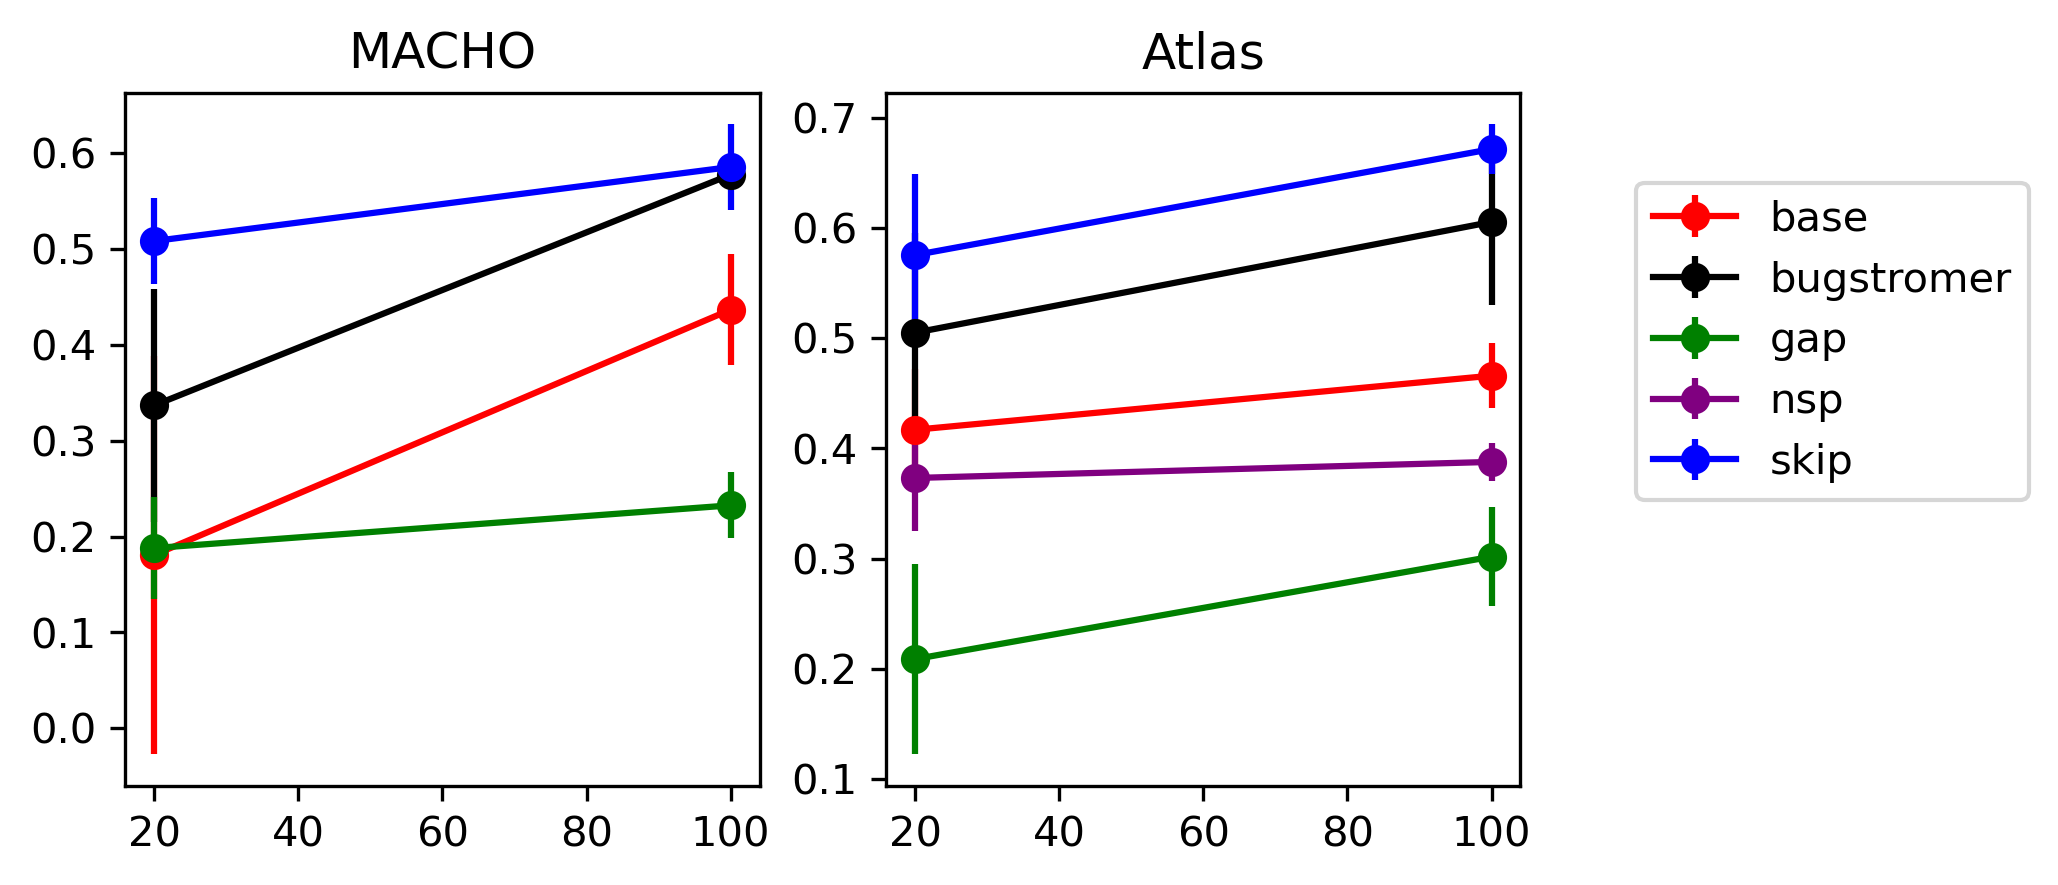

In [115]:
selected = metrics[['dataset', 'spc', 'path', 'fold_n', 'clf_test_f1']]
selected['clf_test_f1'] = selected['clf_test_f1'].astype(float)

colors = {'bugstromer': 'k', 'base': 'r', 'gap': 'g', 'nsp': 'purple', 'skip':'b'}
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
for keys, frame in selected.groupby(['path', 'dataset']):
    values = frame.groupby('spc').mean().reset_index()
    std_values = frame.groupby('spc').std().reset_index()
    print(keys)
    if keys[1] == 'alcock':
        axes[0].errorbar(values['spc'], values['clf_test_f1'],yerr=std_values['clf_test_f1'], 
                         label=keys[0], marker='o', color=colors[keys[0]])
        axes[0].set_title('MACHO')
    else:
        axes[1].errorbar(values['spc'], values['clf_test_f1'],yerr=std_values['clf_test_f1'], 
                         label=keys[0], marker='o', color=colors[keys[0]])
        axes[1].set_title('Atlas')
        
axes[1].legend(bbox_to_anchor=(1.15, .9), ncol=1)
plt.show()

# Learning Curves

In [154]:
frames = []
for r in root:
    for dataset in ['alcock', 'atlas']:
        for spc in [20, 100]:
            try:
                for fold_n in range(3):
                    path = os.path.join(r, 
                        dataset, 
                        'fold_{}'.format(fold_n), 
                        '{}_{}'.format(dataset, spc),  
                        'att_mlp', 
                        'logs')

                    values = get_training_metrics(path)
                    val_metrics = get_validation_metrics(path)
                    val_metrics = val_metrics.rename(
                                        columns={'epoch_loss': 'val_loss', 
                                                'epoch_accuracy': 'val_accuracy'})
                    values = pd.merge(values, 
                             val_metrics[['step', 'val_loss', 'val_accuracy']],
                            on='step', how='right')
                    frames.append((r.split('/')[5], dataset, spc, fold_n, values)) 
            except:
                continue

In [155]:
df = pd.DataFrame(frames, columns=['name', 'dataset', 'spc', 'fold', 'frame'])


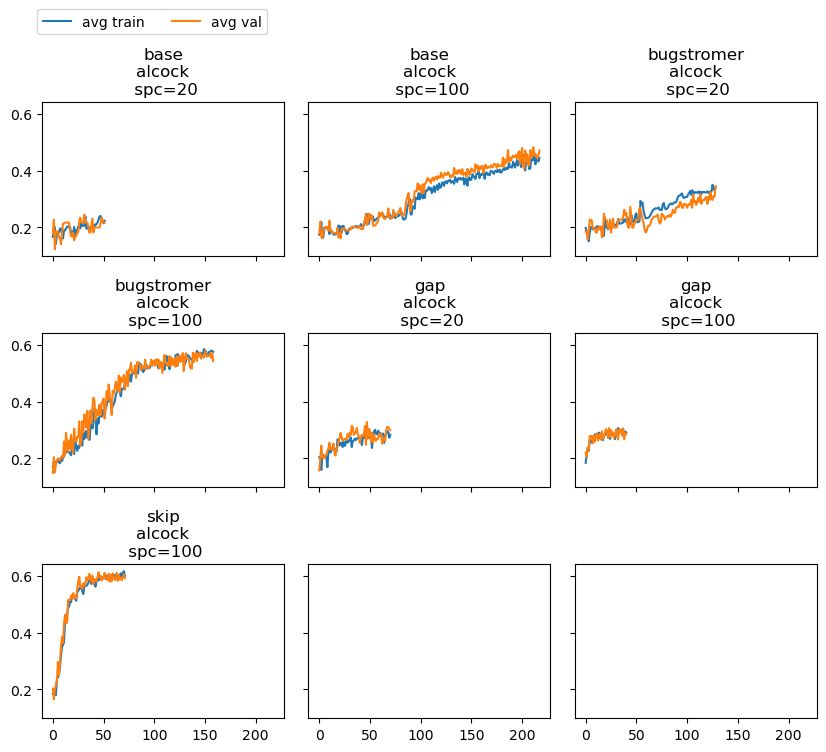

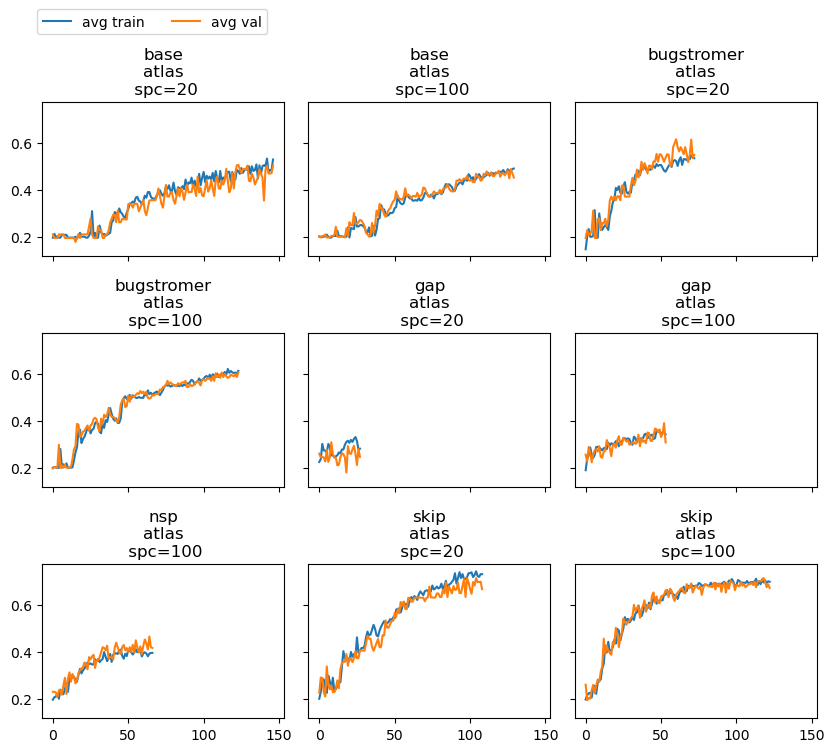

In [167]:

init_groups = df.groupby(['dataset'])
for dataset, f in init_groups:

    groups = f.groupby(['name', 'spc'])
    print()
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharey=True, sharex=True, 
                             gridspec_kw={'hspace':0.5, 'wspace':0.1})
    axes = axes.flatten()

    for i, ((name, spc), df_) in enumerate(groups):

        m = np.mean(df_['frame'].values)    
        axes[i].plot(m['step'], m['epoch_accuracy'], label='avg train')
        axes[i].plot(m['step'], m['val_accuracy'], label='avg val')
        axes[i].set_title('{}\n{}\n spc={}'.format(name, dataset, spc))
#         axes[i].set_yscale('log')
        
    axes[0].legend(bbox_to_anchor=(.96, 1.65), ncol=2)